<a href="https://colab.research.google.com/github/cest0/PPConstrFcst/blob/master/HydroPPForecast_3_2_PredictionEnergyLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Hydro powerplant constraints forecast - energy with LSTM

## Introduction

In this experiment, we are building RNN models using GRU and LSTM cells, trying to beat MLP models that dont incorporate time structure.

For performance reasons, this is executed on google colab, to take advantage of their hardware accelaration capabilities.

This code is very largely inspired by the following tutorial: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statistics 
import math

In [0]:
# from tf.keras.models import Sequential  
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding, LSTM, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

This was developed using google colab and package versions:

In [9]:
tf.__version__

'1.14.0'

In [10]:
tf.keras.__version__

'2.2.4-tf'

In [11]:
pd.__version__

'0.24.2'

## Load Dataset

We load our clean data set.

In [12]:
from google.colab import files
uploaded = files.upload()

Saving clean_dataframe.csv to clean_dataframe.csv


In [0]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv("clean_dataframe.csv", parse_dates=['Date'], date_parser=dateparse, index_col="Date.1")
# rename date column 
df.rename(columns={ df.columns[0]: "Date"}, inplace=True)
df.index = df["Date"]
df.rename(columns={ "Variante Prio": "Max prod"}, inplace=True)

The data imported has been previously cleaned.

These are the top rows of the data-set.

In [14]:
df.head()

,Date,Min prod,Inflow lake 1 [m3],Inflow lake 2 [m3],Inflow lake 3 [m3],Inflow lake 4 [m3],Vol lake 1 [%],Max lake 1 [1000m3],Availability plant 1 [%],Availability plant 2 [%],Availability plant 3 [%],Availability plant 4 [%],SDL [MWh],Weekend,Max prod,PrioH1,PrioP1,PrioH2,PrioP2,PrioH3,PrioP3,PrioH4,PrioP4,TotalAvailablePower
Date,,,,,,,,,,,,,,,,,,,,,,,,
2014-04-01,2014-04-01,0.0,31.0,4.0,129.0,107.0,0.16467,30000.0,1.0,1.0,1.000000,1.0,0.0,False,902.4,4.0,73.8,4.0,66.0,8.0,42.9,0.0,0.0,77.400
2014-04-02,2014-04-02,150.0,0.0,-14.0,148.0,116.0,0.15557,30000.0,1.0,1.0,1.000000,1.0,0.0,False,902.4,4.0,73.8,4.0,66.0,8.0,42.9,0.0,0.0,77.400
2014-04-03,2014-04-03,150.0,10.0,6.0,132.0,118.0,0.14765,30000.0,1.0,1.0,0.291667,1.0,0.0,False,902.4,4.0,73.8,4.0,66.0,8.0,42.9,0.0,0.0,59.125
2014-04-04,2014-04-04,150.0,19.0,6.0,150.0,118.0,0.13716,30000.0,1.0,1.0,0.250000,1.0,0.0,False,902.4,4.0,73.8,4.0,66.0,8.0,42.9,0.0,0.0,58.050
2014-04-05,2014-04-05,180.0,41.0,15.0,148.0,124.0,0.13091,30000.0,1.0,1.0,1.000000,1.0,0.0,True,897.6,4.0,72.6,4.0,66.0,8.0,42.9,0.0,0.0,77.400


### Target variable for Prediction

We will try and predict the future maximum production, contained in column "Max prod"

In [0]:
target_names = ['Max prod']

In [16]:




df_targets = df[target_names]
df_targets.tail()

,Max prod
Date,
2019-06-26,314.759725
2019-06-27,326.450801
2019-06-28,283.883295
2019-06-29,253.906178
2019-06-30,253.906178


### NumPy Arrays

We now convert the inputs that can be sent to the neural network. 

These are the input variables:

In [0]:
regressors = ['Inflow lake 1 [m3]', \
           'Inflow lake 2 [m3]', 'Inflow lake 3 [m3]', 'Inflow lake 4 [m3]', \
           'Vol lake 1 [%]', 'Max lake 1 [1000m3]', 'Availability plant 1 [%]', \
           'Availability plant 2 [%]', 'Availability plant 3 [%]', \
           'Availability plant 4 [%]']

x_data = df[regressors].values

In [18]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (1917, 10)


These are the target variables:

In [0]:
y_data = df_targets.values

In [20]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (1917, 1)


Number of observations in our dataset:

In [21]:
num_data = len(x_data)
num_data

1917

This is train / test split, same as in other parts of the project

In [0]:
train_split = 0.9

Hence number of observations in the training subset:

In [23]:
num_train = int(train_split * num_data)
num_train

1725

And in the test dataset:

In [24]:
num_test = num_data - num_train
num_test

192

Input variables for the training and test subsets:

In [25]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

1917

Output variables for the training and test subsets:

In [26]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

1917

Number of variables as inputs:

In [27]:
num_x_signals = x_data.shape[1]
num_x_signals

10

Number of variables as outptuts:

In [28]:
num_y_signals = y_data.shape[1]
num_y_signals

1

### Scaling our Data

Check out the range of values


In [29]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -482.0
Max: 30000.0


Neural networks usually work best with values between -1 and 1, therefore we need to scale the input data before it is fed into to the neural network. 

The scaler object hels us doing this:

In [0]:
x_scaler = MinMaxScaler()

Let's apply it to the input data

In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)

Except for rounding, it now scaled between 0 and 1.

In [32]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


We use the same scaler on the test data:

In [0]:
x_test_scaled = x_scaler.transform(x_test)

Target values comes from the same dataset but it could have a diffferentrange of values, therefore we use another scaler:

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

Our data is now in the form of a 2-dimension array. The training dataset has got 1725 observations, taht consist of 10 input and 1 output.


In [35]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(1725, 10)
(1725, 1)





Instead of training the Recurrent Neural Network on the complete sequences of 1725 observations, we will use a function to create many batches of short subsequences randomly chosen in the training dataset:

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

A large batch size is required to keep the GPU busy, i.e. at 100% workload. 

In [0]:
batch_size = 256

We will use a sequence-length of 56, which means that each random sequence contains observations for 8 weeks

In [40]:
sequence_length = 1 * 7 * 8
sequence_length

56

And here is the generator object:

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Check out the generator

In [0]:
x_batch, y_batch = next(generator)

It deliver a batch of length 256 at randon, each sequence has 56 samples, and each sampole has 10 variables in input and 1 in output.

In [43]:
print(x_batch.shape)
print(y_batch.shape)

(256, 56, 10)
(256, 56, 1)


We can plot one of the 10 input-signals as an example.

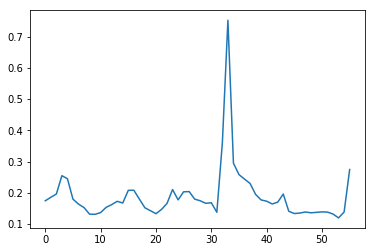

In [44]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

Same for one of the outputs

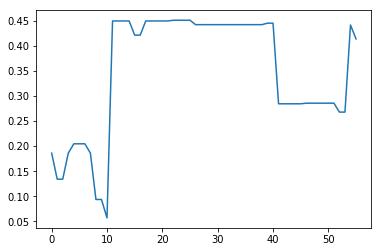

In [45]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity.

In [0]:
model = Sequential()

We can now add 2 Gated Recurrent Unit (GRU) layers to the network. This will have 22 (15+7) outputs for each time-step in the sequence.

We add drop out for normalization.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [48]:
model.add(GRU(units=10,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dropout(0.1))
model.add(GRU(units=7,  
              return_sequences=True))
model.add(Dropout(0.1))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The GRU outputs a batch of sequences of 7 values. We want to predict 1 output-signal, so we add a fully-connected (or dense) layer which maps 7 values down to only 1 value.



We can use a linear activation function on the output. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training. 

In [49]:
from tensorflow.python.keras.initializers import RandomUniform

# Maybe use lower init-ranges.
init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(num_y_signals,
                activation='linear',
                kernel_initializer=init))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 10 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [0]:
warmup_steps = 10

In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [0]:
optimizer = RMSprop(lr=1e-3)

We then compile the Keras model so it is ready for training.

In [53]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


This is a very small model with only two layers. The output shape of `(None, None, 3)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 3 signals. This corresponds to the 3 target signals we want to predict.

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          630       
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 7)           378       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 7)           0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           8         
Total params: 1,016
Trainable params: 1,016
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [0]:
path_checkpoint = 'PowerPredictionLSTM.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [0]:
callback_tensorboard = TensorBoard(log_dir='./PPPredLSTM_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

Also note that the loss sometimes becomes `NaN` (not-a-number). This is often resolved by restarting and running the Notebook again. But it may also be caused by your neural network architecture, learning-rate, batch-size, sequence-length, etc. in which case you may have to modify those settings.

In [60]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0775
Epoch 00001: val_loss improved from inf to 0.04151, saving model to PowerPredictionLSTM.keras
100/100 [==============================] - 26s 256ms/step - loss: 0.0771 - val_loss: 0.0415
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0382
Epoch 00002: val_loss improved from 0.04151 to 0.03143, saving model to PowerPredictionLSTM.keras
100/100 [==============================] - 18s 183ms/step - loss: 0.0382 - val_loss: 0.0314
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0349
Epoch 00003: val_loss improved from 0.03143 to 0.02846, saving model to PowerPredictionLSTM.keras
100/100 [==============================] - 18s 183ms/step - loss: 0.0348 - val_loss: 0.0285
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0313
Epoch 00004: val_loss improved from 0.02846 to 0.02320, saving model to PowerPredictionLSTM.keras
100/100 [===================

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [62]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 125ms/sample - loss: 0.0160


In [63]:
print("loss (test-set):", result)

loss (test-set): 0.015968021005392075


In [0]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [0]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

        #compute errors
        RMSE = round(math.sqrt(metrics.mean_squared_error(signal_true,signal_pred)),2)
        MAE = round(metrics.mean_absolute_error(signal_true,signal_pred),2)
        R2 = round(metrics.r2_score(signal_true,signal_pred)*100, 2)
        print("RMSE: ",RMSE)
        print("MAE: ",MAE)
        print("R2: ",R2)


We now plot the resulting prediction. These plots are in fact a little bit more complicated than they look.

The prediction is not so accurate during the first timesteps because the model has only seen very little input data up to this point.
The model produced a single timestep output data for each tset of input data, meaning the model has only ran during a few timesteps, it knows only little of the input data history and can't produce an accurate prediction yet. In other words, the model has to "warm up" frist by processing maybe about 10 timesteps before it can predict reliable outputs.

That is the reason why we have to ignore this warmup period of about 10 timesteps when starting to calculate the MSE within the loss function. The "warmup period" is displayed as a grey box in the graphs.

Let us beging with an example coming from the training dataset. This is data that the model has already seen during its training so it should perform well on it.

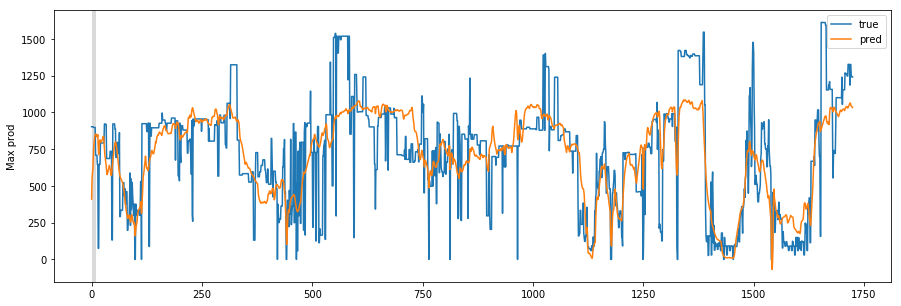

RMSE:  235.63
MAE:  175.02
R2:  59.08


In [68]:
plot_comparison(start_idx=0, length=10000, train=True)

### Example from Test-Set

Let us now consider an example that is taken out the test sbset. Our model has not seen this data yet during its training.


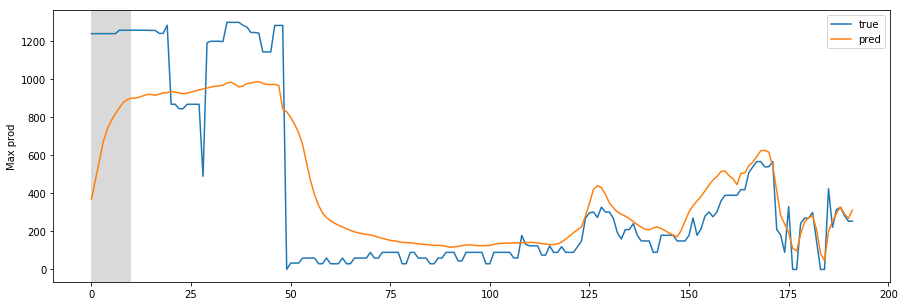

RMSE:  236.61
MAE:  163.35
R2:  73.77


In [67]:
plot_comparison(start_idx=0, length=192, train=False)

## Conclusion

This experiment showed how to use a Recurrent Neural Network to predict a given time series from historical values. Unfortunately, in our case, this is not showing better results than a simple regression.

